In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
from __future__ import division, print_function

The extended Kalman filter (EKF) works by linearizing the system model for each update. Taylor series approximation is used to linearize a set of nonlinear differential equations in EKF.

For example: Consider the function $f(x)=x^2−2x$, this is a non-linear function.

We want a linear approximation of this function so that we can use it in the Kalman filter. 

During each Update of the Kalman filter we know its current state, so if we linearize the function at that value we will have a close approximation.

Assume that our current state is $x = 15$. What would be a good linearization for this function?

We can use any linear function that passes through the curve at $(1.5,-0.75)$

For example, consider using $f(x)=8x−12.75$ as the linearization.

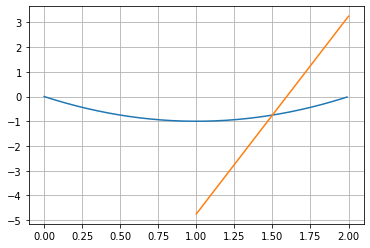

In [33]:
import numpy as np
import matplotlib.pyplot as plt

xs =  np.arange(0, 2, 0.01)
ys = [x**2 - 2*x for x in xs]

def y(x): 
    return 8*x - 12.75

plt.plot(xs, ys)
plt.plot([1,2], [y(1), y(2)])
plt.grid()

This is not a good linearization for $f(x)$. It is exact for $x=1.5$, but quickly diverges when $x$ varies by a small amount.

A much better approach is to use the slope of the function at the evaluation point as the linearization. We find the slope by taking the first derivative of the function:

$$f(x)=x^2−2x$$

$$\frac{dx}{dy} = 2x - 2$$

so the slope at 1.5 is 

$$=2*x-2$$

$$=2*1.5-2$$

$$= 12 ∗ 1.5−2$$

$$= 1$$

therefore, m = 1, x = 1.5 and y = -0.75

$$ y = m * x + c $$

$$ -0.75 = 1 * 1.5 + c$$

hence, $$ c = 2.25 $$

Let's plot that.

(-1.5, 1)

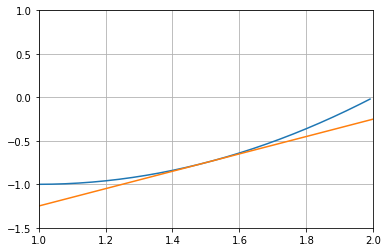

In [26]:
def y(x): 
    return x - 2.25

plt.plot(xs, ys)
plt.plot([1, 2], [y(1), y(2)])
plt.grid()
plt.xlim(1, 2)
plt.ylim([-1.5, 1])

 This linearization is much better. It is still exactly correct at x=1.5, but the errors are very small as x varies.

**Linearizing the kalman filter**

To implement the extended Kalman filter we will leave the linear equations as they are, and use partial derivatives to evaluate the system matrix **F** and the measurement matrix **H** at the state **X** at time **t**.

Note: **F** also depends on the control input vector **u**

$$F \equiv \frac{\partial f}{\partial x}|x_t,u_t$$

$$H \equiv \frac{\partial h}{\partial x}|x_t$$

All this means is that at each update step we compute **F** as the partial derivative of our function f() evaluated at x.

Let's understand this with an example

**Example : Tracking a flying airplane by using ground based radar**

1) Radars work by emitting a beam of radio waves and scanning for a return bounce. 

2) Anything in the beam's path will reflects some of the signal back to the radar.

3) Slant distance (the straight line distance from the radar installation to the object) can be computed by knowing the amount of time taken for the reflected signal to get back to the radar system.

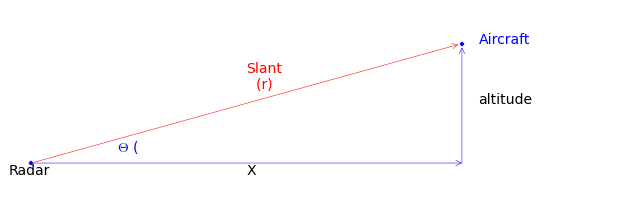

In [37]:
from IPython.display import Image
Image("C:/Users/suhas/Pictures/Radar.png")

For this example we want to take the slant range measurement from the radar and compute the horizontal position (distance of aircraft from the radar measured over the ground) and altitude of the aircraft, as shown in the above diagram.

Our measurement model is a non-linear function $x = \sqrt(slant^2 - altitude^2)$

<u>**Prediction step:**</u>

$$Linear:$$

<font color='red'> $$x' = Fx + Bu +w$$</font> 

<font color='blue'> $$P = FPF^T + Q$$</font> 

$$Non-linear:$$

<font color='red'> $$x' = f(x,u)$$</font> 

<font color='blue'> $$P' = FPF^T + Q$$</font> 


<u>**Updation step:**</u>

$$Linear:$$

<font color='blue'> $$K = P' H^T (H P' H^T + R)^{-1}$$</font> 

<font color='red'> $$x= x'+ K(z - H x')$$</font> 

<font color='blue'> $$P = P'(I - KH)$$</font> 

$$Non-Linear:$$

<font color='blue'> $$K = P' H^T (H P' H^T + R)^{-1}$$</font> 

<font color='red'> $$x= x'+ K(z - h(x))$$</font> 

<font color='blue'> $$P = P'(I - KH)$$</font> 

As we can see there are two minor changes to the Kalman filter equations wrt extended kalman filter, which is highlighted in red.

In the Kalman filter, **Fx** is how we compute the new state based on the old state. However, in a nonlinear system we cannot use linear algebra to compute this transition. So instead we hypothesize a nonlinear function **f()** which performs this function.

Likewise, in the Kalman filter we convert the state to a measurement with the linear function **Hx**. For the extended Kalman filter we replace this with a nonlinear function **h()**.

**So, how do we implement and use f() and h() in the Kalman filter if they are nonlinear?**

The rest of the equations are unchanged, so f() and h() must produce a matrix that approximates the values of the matrices F and H at the current value for x. We do this by computing the partial derivatives of the state and measurements functions.

**Note** : Dimensions of the terms used in the equation

| **Term** | **Name** | **Dimensions** |
| -------- | -------- | -------------- |
| x        | State Vector | $(n_x,1)$  |
| F        | State Transition Matrix | $(n_x,n_x)$  |
| B        | Control Matrix | $(n_x,n_u)$ |
| u        | Input Variable | $(n_u,1)$  |
| P        | Estimate Uncertainity | $(n_x,n_x)$  |
| Q        | Process Noise Uncertainity | $(n_x,n_x)$  |
| R        | Measurement Uncertainty | $(n_z,n_z)$  |
| K        | Kalman Gain | $(n_x,n_x)$  |
| H        | Observation Matrix | $(n_z,n_x)$  |
| z        | Measurement | $(n_z,1)$  |
| w        | Process noise Vector | $(n_x,1)$  |



Let's understand this with the example

So we want to track the position of an aircraft assuming a constant velocity and altitude, and measurements of the slant distance to the aircraft. 

That means we need 3 state variables - 

1) position (horizontal distance)

2) velocity

3) altitude

$$X = \begin{bmatrix}position \\
velocity\\
altitude
\end{bmatrix} = \begin{bmatrix}X_{pos} \\
X_{vel}\\
X_{alt}
\end{bmatrix} $$

Design the System Model : We will model this as a set of differential equations. 

So we need an equation in the form 

$$\dot{x} = A x + w$$

The first row is $\dot{x}_{pos}$, which is the velocity of the airplane.  

$$\dot{x}_{pos} =  x_{vel}$$

The second row is $\dot{x}_{vel}$, which is the acceleration of the airplane. We assume constant velocity, so the acceleration equals zero. However, we also assume system noise due to things like buffeting winds, errors in control inputs, and so on, so we need to add an error $w_{acc}$ to the term.

$$\dot{x}_{vel} =  0 + w_{acc}$$

The final row contains $\dot{x}_{alt}$, which is the rate of change in the altitude. We assume a constant altitude, so this term is 0, but as with acceleration we need to add in a noise term to account for things like wind, air density, and so on.

$$\dot{x}_{alt} =  0 + w_{alt}$$

We turn this into matrix form with the following:

$$\dot{x} = \begin{bmatrix}0 & 1 & 0 \\
0 & 0 & 0\\
0 & 0 & 0
\end{bmatrix} * \begin{bmatrix}x_{pos} \\
x_{vel}\\
x_{alt}
\end{bmatrix} + \begin{bmatrix}0 \\
w_{acc}\\
w_{alt}
\end{bmatrix}$$

Now we have our differential equations for the system we can somehow solve for them to get our familiar Kalman filter state equation

$$x' = F x$$

Given the partial differential equation

$$F = \frac{\partial f(x)}{\partial x}$$

We need an equation in the form

$$\dot{x}=Ax+w$$

The variables x_pos and x_alt are independent so we can compute them separately. The differential equations for motion in one dimension are:

$$x_{vel} = \dot{x_{pos}}$$
$$x_{acc} = \dot{x_{vel}} = 0$$

Now we put the differential equations into state-space form.

$$\begin{bmatrix}\dot{x_{pos}}\\ \dot{x_{vel}} \end{bmatrix} = \begin{bmatrix}0 & 1\\ 0&0 \end{bmatrix} * \begin{bmatrix}x_{pos}\\ \dot{x_{pos}} \end{bmatrix}$$

$$\dot{x} = Ax$$

A is the system dynamics matrix. It describes a set of linear differential equations.

From it we must compute the state transition matrix F. F describes a discrete set of linear equations which compute x for a discrete time step Δt.

A common way to compute F is to use the power series expansion of the matrix exponential:

$$F(\Delta t)= e^{A \Delta t}= I + A \Delta t +  \frac{(A \Delta t)^2}{2!} + \frac{(A \Delta t)^3}{3!} + ...$$

$A^2 = \begin{bmatrix}0 & 0\\ 0&0 \end{bmatrix}$ , so all higher powers of A are also 0. Thus the power series expansion is:

$$F(\Delta t)= I + A \Delta t $$

$$F= \begin{bmatrix}1 & 0\\ 0&1 \end{bmatrix} + \begin{bmatrix}0 & 1\\ 0&0 \end{bmatrix} \Delta t $$

$$F= \begin{bmatrix}1 & \Delta t \\ 0&1 \end{bmatrix}$$

Since we have 3 state variables we model this as:

$$F= \begin{bmatrix}1 & \Delta t & 0 \\ 0&1&0 \\ 0&0&1 \end{bmatrix}$$

**Modelling measurement function**

The measurement function for our filter needs to take the filter state x and turn it into a slant range distance.

$$h(x) = \sqrt(x_{pos}^2+x_{alt}^2)$$

The relationship between the slant distance and the position on the ground is nonlinear due to the square root term. 

So what we need to do is linearize the measurement function at some point. 

The best way to linearize an equation at a point is to find its slope, which we do by taking its derivative.

$$H \equiv \frac{\partial h}{\partial x}|x_t$$

The derivative of a matrix is called a Jacobian, which in general takes the form

$$\frac{\partial h}{\partial x} = \begin{bmatrix}\frac{\partial h1}{\partial x1} & \frac{\partial h1}{\partial x2} & ... \\
\frac{\partial h2}{\partial x1}& \frac{\partial h2}{\partial x2} & ...\\
... & ... & ...
\end{bmatrix}$$

In other words, each element in the matrix is the partial derivative of the function h with respect to the variables x. 

For our problem we have

$$H = \begin{bmatrix}\frac{\partial h}{\partial x_{pos}}&\frac{\partial h}{\partial x_{vel}}&\frac{\partial h}{\partial x_{alt}}\end{bmatrix}$$

where, $$h(x) = \sqrt(x_{pos}^2+x_{alt}^2)$$  (given above)

Solving each in turn:

1) solving h(x) with respect to x_pos

$$\frac{\partial h}{\partial x_{pos}} = \frac{\partial \sqrt(x_{pos}^2+x_{alt}^2}{\partial x_{pos}}$$
$$\frac{\partial h}{\partial x_{pos}} = \frac{x_{pos}}{x_{pos}^2+x_{alt}^2}$$

2) solving h(x) with respect to x_vel

$$\frac{\partial h}{\partial x_{vel}} = \frac{\partial \sqrt(x_{pos}^2+x_{alt}^2}{\partial x_{vel}}$$
$$\frac{\partial h}{\partial x_{vel}} = 0$$

3) solving h(x) with respect to x_alt

$$\frac{\partial h}{\partial x_{alt}} = \frac{\partial \sqrt(x_{pos}^2+x_{alt}^2}{\partial x_{alt}}$$
$$\frac{\partial h}{\partial x_{alt}} = \frac{x_{alt}}{x_{pos}^2+x_{alt}^2}$$

So H matrix is,

$$H = \begin{bmatrix} \frac{x_{pos}}{x_{pos}^2+x_{alt}^2} & 0 & \frac{x_{alt}}{x_{pos}^2+x_{alt}^2} \end{bmatrix}$$

In [16]:
import numpy as np
import sympy as sp
sp.init_printing()

x_pos, x_vel, x_alt = sp.symbols('x_pos, x_vel x_alt')

h = sp.Matrix([sp.sqrt(x_pos**2 + x_alt**2)])
X = sp.Matrix([x_pos, x_vel, x_alt])

h.jacobian(X)

⎡       xₚₒₛ                   xₐₗₜ       ⎤
⎢──────────────────  0  ──────────────────⎥
⎢   _______________        _______________⎥
⎢  ╱     2       2        ╱     2       2 ⎥
⎣╲╱  xₐₗₜ  + xₚₒₛ       ╲╱  xₐₗₜ  + xₚₒₛ  ⎦

**Designing Q**

Now we need to design the process noise matrix Q. 

From the previous section we have the system equation

$$\dot{x} = \begin{bmatrix}0 & 1 & 0 \\
0 & 0 & 0\\
0 & 0 & 0
\end{bmatrix} * \begin{bmatrix}x_{pos} \\
x_{vel}\\
x_{alt}
\end{bmatrix} + \begin{bmatrix}0 \\
w_{acc}\\
w_{alt}
\end{bmatrix}$$

where our process noise is

$$w = \begin{bmatrix}0 \\
w_{acc}\\
w_{alt}
\end{bmatrix}$$

We know that $$Q = E(ww^T)$$

Where E(.) is the expected value

$$Q = \int_{0}^{dt} F(t) ww^T F(t)^T dt$$

In [20]:
sympy.init_printing(use_latex='mathjax')
w_vel, w_alt, dt = sp.symbols('w_vel w_alt \Delta{t}')

w = Matrix([[0, w_vel, w_alt]]).T
F = Matrix([[1, dt, 0], [0, 1, 0], [0,0,1]])

q = w*w.T

sympy.integrate(F*q*F.T, (dt, 0, dt))

⎡           3     2              2     2             2          ⎤
⎢  \Delta{t} ⋅wᵥₑₗ      \Delta{t} ⋅wᵥₑₗ     \Delta{t} ⋅wₐₗₜ⋅wᵥₑₗ⎥
⎢  ────────────────     ────────────────    ────────────────────⎥
⎢         3                    2                     2          ⎥
⎢                                                               ⎥
⎢           2     2                                             ⎥
⎢  \Delta{t} ⋅wᵥₑₗ                     2                        ⎥
⎢  ────────────────      \Delta{t}⋅wᵥₑₗ     \Delta{t}⋅wₐₗₜ⋅wᵥₑₗ ⎥
⎢         2                                                     ⎥
⎢                                                               ⎥
⎢         2                                                     ⎥
⎢\Delta{t} ⋅wₐₗₜ⋅wᵥₑₗ                                       2   ⎥
⎢────────────────────  \Delta{t}⋅wₐₗₜ⋅wᵥₑₗ    \Delta{t}⋅wₐₗₜ    ⎥
⎣         2                                                     ⎦